## Step 1: Calculate the cases received and trial rate at an aggregated level

In [1]:
import pandas as pd

# Load the demographic data that was cleaned previously
demographic = pd.read_excel('/Users/Olivia/Desktop/CTC/Demographic_Cleaned.xlsx', sheet_name='Demographic Cleaned')

# Remove unecessary columns
demographic = demographic.iloc[:, 1:]

# Load the crime data that was cleaned previously
crime = pd.read_excel('/Users/Olivia/Desktop/CTC/Criminal Offenses_Cleaned.xlsx', sheet_name='Criminal Offenses Cleaned')

# Remove unecessary columns
crime = crime.iloc[:, 1:]

In [2]:
# Calculate the total cases received, cases disposed and cases disposed after a trial by geography
result = crime.groupby('Link Geography').agg({
    'Cases Received': 'sum',          
    'Cases Disposed': 'sum',
    'Cases Disposed Following a Trial TOTAL': 'sum' 
}).reset_index()

# Rename columns for clarity
result.rename(columns={
    'Cases Received': 'Total Cases Received',
    'Cases Disposed': 'Total Cases Disposed',
    'Cases Disposed Following a Trial TOTAL': 'Total Trial'
}, inplace=True)

In [3]:
# Calculate 'Trial Rate' and add it as a new column
result['Trial Rate'] = result['Total Trial'] / result['Total Cases Disposed']

# Replace Null values in 'Trial Rate' with 0
result['Trial Rate'] = result['Trial Rate'].fillna(0)

print(result.head())

                   Link Geography  Total Cases Received  Total Cases Disposed  \
0        Brant County Health Unit                   403                   484   
1        Chatham-Kent Health Unit                   234                   264   
2    City of Hamilton Health Unit                   639                   725   
3     City of Toronto Health Unit                  3605                  3998   
4  District of Algoma Health Unit                   316                   288   

   Total Trial  Trial Rate  
0            5    0.010331  
1            3    0.011364  
2           12    0.016552  
3           85    0.021261  
4            0    0.000000  


In [4]:
# Perform the left join
merged_data = pd.merge(demographic, result, how='left', left_on='Geography', right_on='Link Geography')

# Display the merged DataFrame
print(merged_data.head())

                        Geography postalcode  \
0        Brant County Health Unit   N3R 1G7    
1        Chatham-Kent Health Unit   N7M 5L8    
2    City of Hamilton Health Unit   L8P 4S6    
3     City of Toronto Health Unit    M5B 1W2   
4  District of Algoma Health Unit    P6B 0A8   

   Census families in private households  Female lone-parent families  \
0                                  39470                         5965   
1                                  30415                         3985   
2                                 144120                        21925   
3                                 690340                       123530   
4                                  34300                         4650   

   Female lone-parent families, proportion of census families (percent)  \
0                                               15.1                      
1                                               13.1                      
2                                              

## Step 2: Determine the correlation between cases and other features

In [5]:
# Feature selection: Use the percentage of total population for selected columns instead of using the absolute value

# Choose columns that end with '(percent)' as independent variables
percent_columns = [col for col in merged_data.columns if col.endswith('(percent)')]

# Choose columns as dependent variables
specific_columns = ['Total Cases Received','Trial Rate']

# Combine the selected columns to create a new table
selected_columns = percent_columns + specific_columns

# Ensure all specified columns exist in the DataFrame
existing_columns = [col for col in selected_columns if col in merged_data.columns]

# Select only those columns
merged_data = merged_data[existing_columns]

print(merged_data.head())

   Female lone-parent families, proportion of census families (percent)  \
0                                               15.1                      
1                                               13.1                      
2                                               15.2                      
3                                               17.9                      
4                                               13.6                      

   Lone-parent families, proportion of census families (percent)  \
0                                               18.9               
1                                               16.6               
2                                               18.9               
3                                               21.3               
4                                               17.4               

   Male lone-parent families, proportion of census families (percent)  \
0                                                3.8               

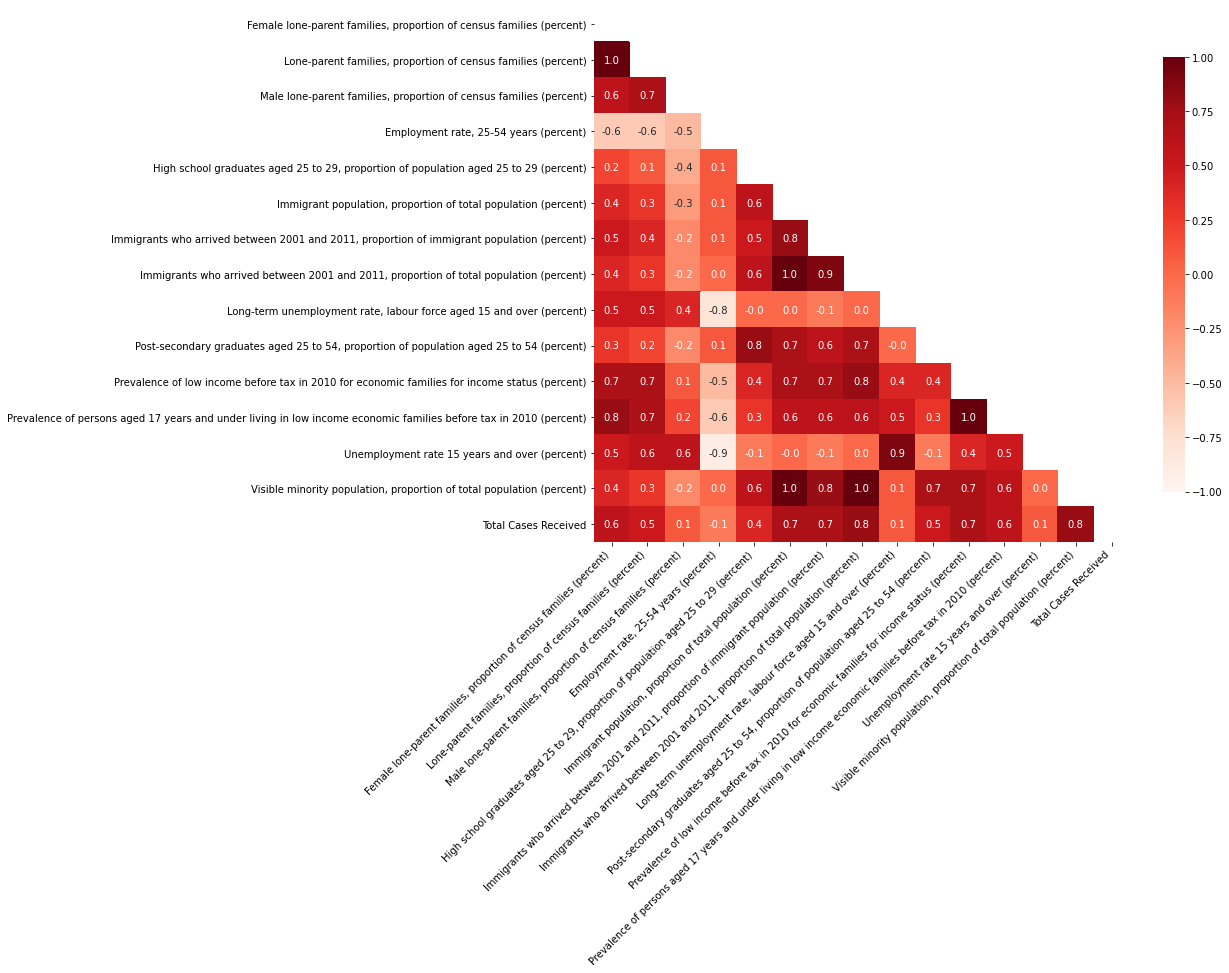

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# To predict only the 'Total Case Received', remove the 'Trial Rate' column
cases_received = merged_data.drop(columns='Trial Rate')

# Compute the correlation matrix
correlation_matrix = cases_received.corr(method="pearson").round(1)

# Create a mask to cover the upper triangle of the matrix
my_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust size based on the number of variables
sns.heatmap(correlation_matrix, cmap="Reds", vmin=-1, vmax=1, annot=True, fmt='.1f', 
            square=True, mask=my_mask, cbar_kws={'shrink': .8})

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [7]:
# Find the VIF of each feature. High VIF feature can be removed from regression model to avoid multicollinearity

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number]) 

    X = sm.add_constant(numeric_df)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i+1) for i in range(numeric_df.shape[1])]

    return vif_data

if __name__ == "__main__":
    df = merged_data
    vif_df = calculate_vif(df)
    print(vif_df.sort_values(by='VIF', ascending=False))

                                              Feature          VIF
1   Lone-parent families, proportion of census fam...  4010.663440
0   Female lone-parent families, proportion of cen...  3095.705297
2   Male lone-parent families, proportion of censu...   174.115668
7   Immigrants who arrived between 2001 and 2011, ...   114.547629
5   Immigrant population, proportion of total popu...    79.559255
10  Prevalence of low income before tax in 2010 fo...    56.422578
13  Visible minority population, proportion of tot...    56.363248
11  Prevalence of persons aged 17 years and under ...    54.061828
12      Unemployment rate 15 years and over (percent)    34.525300
8   Long-term unemployment rate, labour force aged...    21.420663
3              Employment rate, 25-54 years (percent)    20.448342
6   Immigrants who arrived between 2001 and 2011, ...    10.405073
14                               Total Cases Received     6.886878
4   High school graduates aged 25 to 29, proportio...     6.45

## Step 3: Determine the correlation between trial rate and other features

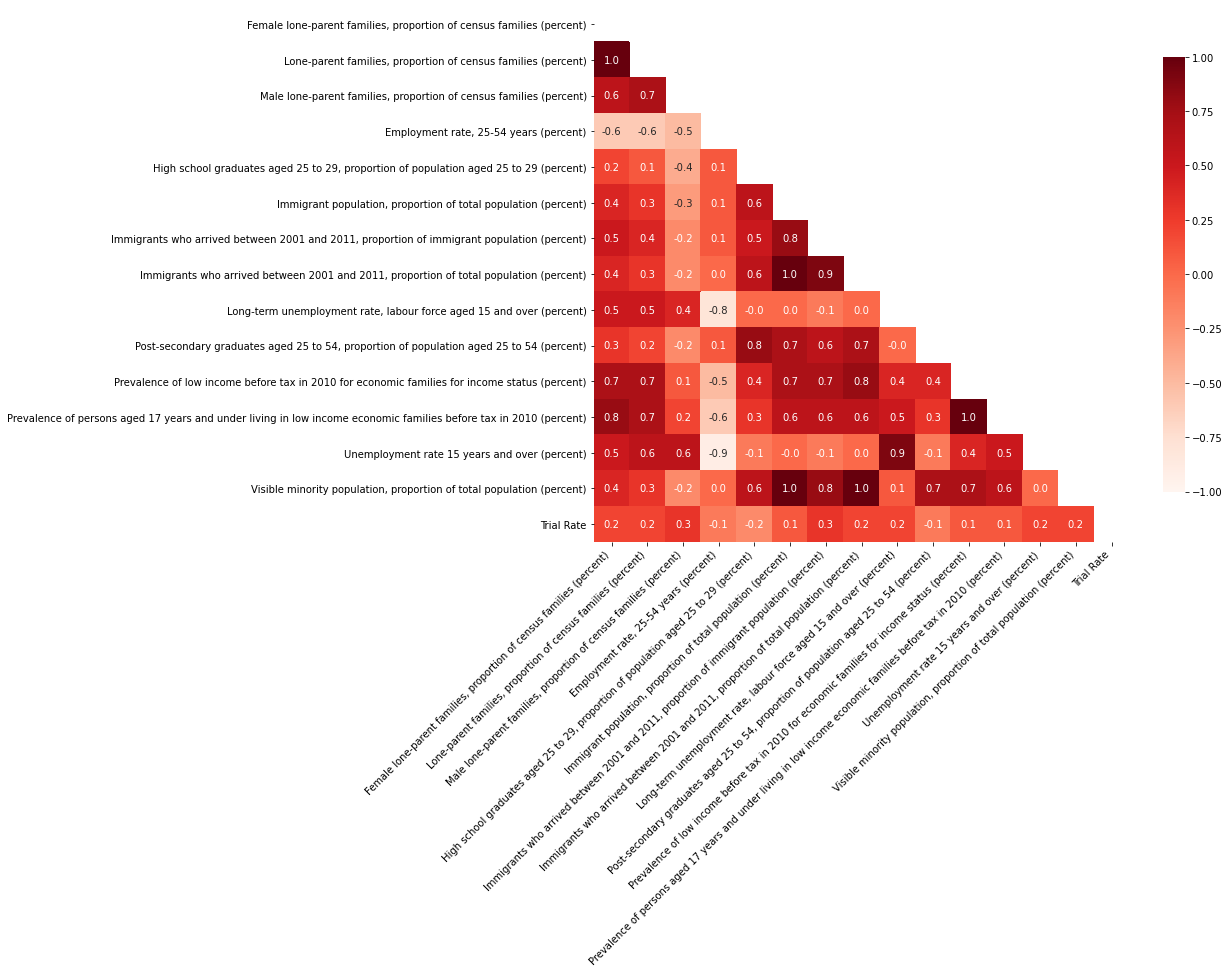

In [8]:
# To predict only the 'Trial Rate', remove the 'Total Case Received' column
trial_rate = merged_data.drop(columns='Total Cases Received')

# Compute the correlation matrix
correlation_matrix_1 = trial_rate.corr(method="pearson").round(1)

# Create a mask to cover the upper triangle of the matrix
my_mask = np.triu(np.ones_like(correlation_matrix_1, dtype=bool))

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust size based on the number of variables
sns.heatmap(correlation_matrix_1, cmap="Reds", vmin=-1, vmax=1, annot=True, fmt='.1f', 
            square=True, mask=my_mask, cbar_kws={'shrink': .8})

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

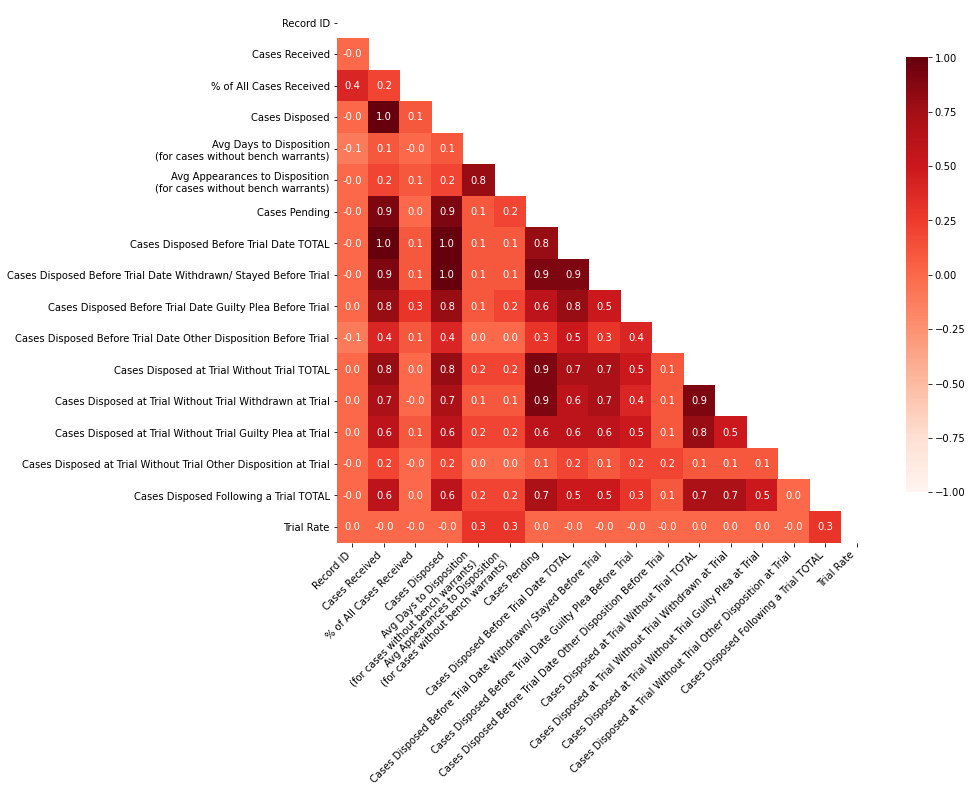

In [9]:
# Use the crime table that was previously cleaned

# Compute a new 'Trial Rate' column with crime data
result = crime.drop(columns = 'Trial Rate')
result['Trial Rate'] = result['Cases Disposed Following a Trial TOTAL'] / result['Cases Disposed']

# Replace Null values in 'Trial Rate' with 0
result['Trial Rate'] = result['Trial Rate'].fillna(0)

# Drop non-numerical columns
trial_rate_updated = result.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix_2 = trial_rate_updated.corr(method="pearson").round(1)

# Create a mask to cover the upper triangle of the matrix
my_mask = np.triu(np.ones_like(correlation_matrix_2, dtype=bool))

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust size based on the number of variables
sns.heatmap(correlation_matrix_2, cmap="Reds", vmin=-1, vmax=1, annot=True, fmt='.1f', 
            square=True, mask=my_mask, cbar_kws={'shrink': .8})

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

## Step 4: Build a linear regression model to predict cases received

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Test: Use variables with correlation coefficient => 0.5

independent_vars = [
        'Female lone-parent families, proportion of census families (percent)',
        'Lone-parent families, proportion of census families (percent)',
       'Immigrant population, proportion of total population (percent)',
       'Immigrants who arrived between 2001 and 2011, proportion of immigrant population (percent)',
       'Immigrants who arrived between 2001 and 2011, proportion of total population (percent)',
       'Post-secondary graduates aged 25 to 54, proportion of population aged 25 to 54 (percent)',
       'Prevalence of low income before tax in 2010 for economic families for income status (percent)',
       'Prevalence of persons aged 17 years and under living in low income economic families before tax in 2010 (percent)',
       'Visible minority population, proportion of total population (percent)'
]

# Select the independent variables and the dependent variable
X = cases_received[independent_vars]
y = cases_received['Total Cases Received']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
model_output = model.summary()

print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Total Cases Received   R-squared:                       0.869
Model:                              OLS   Adj. R-squared:                  0.803
Method:                   Least Squares   F-statistic:                     13.26
Date:                  Thu, 29 Aug 2024   Prob (F-statistic):           2.98e-06
Time:                          09:00:23   Log-Likelihood:                -192.86
No. Observations:                    28   AIC:                             405.7
Df Residuals:                        18   BIC:                             419.0
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------

In [11]:
# Model 1: Build a new regression model with % of immigrants and female lone-parent families

independent_vars = [
        'Immigrants who arrived between 2001 and 2011, proportion of total population (percent)',
        'Female lone-parent families, proportion of census families (percent)'
]

# Check for missing columns
missing_columns = [col for col in independent_vars if col not in cases_received.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

# Select the independent variables and the dependent variable
X = cases_received[independent_vars]
y = cases_received['Total Cases Received']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Total Cases Received   R-squared:                       0.722
Model:                              OLS   Adj. R-squared:                  0.700
Method:                   Least Squares   F-statistic:                     32.47
Date:                  Thu, 29 Aug 2024   Prob (F-statistic):           1.12e-07
Time:                          09:00:23   Log-Likelihood:                -203.38
No. Observations:                    28   AIC:                             412.8
Df Residuals:                        25   BIC:                             416.8
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [12]:
# Model 2: Build a new regression model with % of visible minorities and female lone-parent families

# Define the independent variables
independent_vars = [
    'Visible minority population, proportion of total population (percent)',
    'Female lone-parent families, proportion of census families (percent)',
]

# Check for missing columns
missing_columns = [col for col in independent_vars if col not in cases_received.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

# Select the independent variables and the dependent variable
X = cases_received[independent_vars]
y = cases_received['Total Cases Received']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
model_output = model.summary()
print(model_output)


                             OLS Regression Results                             
Dep. Variable:     Total Cases Received   R-squared:                       0.703
Model:                              OLS   Adj. R-squared:                  0.679
Method:                   Least Squares   F-statistic:                     29.58
Date:                  Thu, 29 Aug 2024   Prob (F-statistic):           2.58e-07
Time:                          09:00:23   Log-Likelihood:                -204.31
No. Observations:                    28   AIC:                             414.6
Df Residuals:                        25   BIC:                             418.6
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

## Step 4: Build a linear regression model to predict trial rate

In [13]:
# Model 3: Use variables with correlation coefficient => 0.2

independent_vars = [
        'Male lone-parent families, proportion of census families (percent)',
       'Immigrants who arrived between 2001 and 2011, proportion of immigrant population (percent)',
        'Lone-parent families, proportion of census families (percent)',
        'Unemployment rate 15 years and over (percent)'
]

# Select the independent variables and the dependent variable
X = trial_rate[independent_vars]
y = trial_rate['Trial Rate']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
model_output = model.summary()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Trial Rate   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.084
Method:                 Least Squares   F-statistic:                    0.4764
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.753
Time:                        09:00:23   Log-Likelihood:                 88.250
No. Observations:                  28   AIC:                            -166.5
Df Residuals:                      23   BIC:                            -159.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [14]:
# Model 4: Use variables with correlation coefficient => 0.3

independent_vars = [
       'Male lone-parent families, proportion of census families (percent)',
       'Immigrants who arrived between 2001 and 2011, proportion of immigrant population (percent)'
]

# Select the independent variables and the dependent variable
X = trial_rate[independent_vars]
y = trial_rate['Trial Rate']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
model_output = model.summary()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Trial Rate   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9713
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.392
Time:                        09:00:23   Log-Likelihood:                 88.183
No. Observations:                  28   AIC:                            -170.4
Df Residuals:                      25   BIC:                            -166.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [15]:
# Model 5: Removed the variable that has p-value larger than 0.05

independent_vars = [
       'Immigrants who arrived between 2001 and 2011, proportion of immigrant population (percent)'
]

# Select the independent variables and the dependent variable
X = trial_rate[independent_vars]
y = trial_rate['Trial Rate']

# Add a constant to the independent variables for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
model_output = model.summary()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Trial Rate   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.714
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.202
Time:                        09:00:23   Log-Likelihood:                 88.029
No. Observations:                  28   AIC:                            -172.1
Df Residuals:                      26   BIC:                            -169.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

## Conclusion
#### Criminal Cases: The key drivers of criminal cases are female lone-parent families, % of immigrants and % of visible minorities as these features show high correlation and have p-values < 0.05.
#### Trial Rate: Couldn't identify the key drivers of trial rate. All features show low correlation and have p-values > 0.05.